In [163]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_utils import *
from model import *
import pickle
import json
import random
import nltk

In [261]:
checkpoint = torch.load('../weight/star_sden_plus_0/model.pkl',map_location=lambda storage, loc: storage)
checkpoint_slm = torch.load('../weight/star_sden_plus_0.5/model.pkl',map_location=lambda storage, loc: storage)

In [262]:
config = checkpoint['config']

In [263]:
word2index, slot2index, intent2index = checkpoint['vocab'], checkpoint['slot_vocab'], checkpoint['intent_vocab']
vocab = (word2index, slot2index, intent2index)
config.test_path = '../data/kvret/test_multi.iob'
test_data, test_slm_data = prepare_dataset(config.test_path, config, vocab)
index2intent = {v:k for k,v in checkpoint['intent_vocab'].items()}
index2slot = {v:k for k,v in checkpoint['slot_vocab'].items()}
index2word = {v:k for k,v in checkpoint['vocab'].items()}

100%|██████████| 805/805 [00:00<00:00, 10763.78it/s]


In [264]:
model = SDEN_plus(len(checkpoint['vocab']),config.embed_size,config.hidden_size,
             len(checkpoint['slot_vocab']),len(checkpoint['intent_vocab']))
model_slm = SDEN_plus(len(checkpoint['vocab']),config.embed_size,config.hidden_size,
             len(checkpoint['slot_vocab']),len(checkpoint['intent_vocab']))
model.load_state_dict(checkpoint['model'])
model_slm.load_state_dict(checkpoint_slm['model'])
model.eval()
model_slm.eval()

SDEN_plus(
  (embed): Embedding(1616, 100, padding_idx=0)
  (bigru_m): GRU(100, 64, batch_first=True, bidirectional=True)
  (bigru_c): GRU(100, 64, batch_first=True, bidirectional=True)
  (context_encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): SELU()
  )
  (session_encoder): GRU(128, 128, batch_first=True, bidirectional=True)
  (decoder_1): GRU(100, 128, batch_first=True, bidirectional=True)
  (decoder_2): LSTM(512, 128, batch_first=True, bidirectional=True)
  (intent_linear): Linear(in_features=256, out_features=4, bias=True)
  (slot_linear): Linear(in_features=256, out_features=28, bias=True)
  (slm_linear): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3)
)

In [266]:
for batch in data_loader(test_data, 1, False):
    history, current,_,_ = batch[0]
    h,c,slot,intent = pad_to_batch(batch, word2index, slot2index)
    slot = slot.tolist()[0] 
    
    slot_p, _ = model(h_pad, c)
    slot_p_slm, _ = model_slm(h_pad, c)
    slot_p = slot_p.argmax(-1)
    slot_p_slm = slot_p_slm.argmax(-1)
    temp = ' '.join([index2word[idx] for idx in current.tolist()[0]])

    if slot_p_slm.tolist()==slot and slot_p.tolist() != slot:
        print('+++++++++++++++')
        print('history:')
        for hh in history:
            print(' '.join([index2word[idx] for idx in hh.tolist()[0]]))
        print('current:'+' '.join([index2word[idx] for idx in current.tolist()[0]]))
        print('slot_label:'+' '.join([index2slot[idx] for idx in slot]))
        print('slot_pred:'+' '.join([index2slot[idx] for idx in slot_p.tolist()]))
        print('slot_pred_slm:'+' '.join([index2slot[idx] for idx in slot_p_slm.tolist()]))

+++++++++++++++
history:
<null>
current:what 's the temperature going to be like on friday
slot_label:O O O B-weather_attribute O O O O O B-date
slot_pred:O O O B-weather_attribute O O O O O B-weather_attribute
slot_pred_slm:O O O B-weather_attribute O O O O O B-date
+++++++++++++++
history:
<null>
take me to my friend 's house
your friends house is on 5677 <unk> 4th street, there is moderate traffic on our way but we're just 1 miles away
current:what about the address of my home .
slot_label:O O O O O O B-poi O
slot_pred:O O O O O O B-poi_type O
slot_pred_slm:O O O O O O B-poi O
+++++++++++++++
history:
<null>
current:schedule conference with sales team on the 11th of this month 9 am
slot_label:O B-event O B-party I-party O O B-date I-date I-date I-date B-time I-time
slot_pred:O B-event O B-party I-party O B-date B-date I-date I-date I-date B-time I-time
slot_pred_slm:O B-event O B-party I-party O O B-date I-date I-date I-date B-time I-time
+++++++++++++++
history:
<null>
what is the 

# Case1
history:
what is the weather going to be like tomorrow show me the 7 day forecast
what city are you interested in?
fresno : there will be hail tomorrow ?
tomorrow in fresno it will rain
current:
so no hail tomorrow in fresno ?
slot_label:
O O B-weather_attribute B-date O B-location O
slot_pred:
O O B-date I-date O B-location O
slot_pred_slm:
O O B-weather_attribute B-date O B-location O

# Case2
history:

please give the directions to a nearby hospital .
the only nearby hospital is stanford express care which is 5 miles away.
and how is the traffic ?
there is currently a road block nearby on the 5 mile route to stanford express <unk>
current:
could you give me the address and directions via a shortest route ?
slot_label:
O O O O O O O O O O B-distance O O
slot_pred:
O O O O O O O O O O B-traffic_info I-traffic_info O
slot_pred_slm:
O O O O O O O O O O B-distance O O

In [253]:
class MemNet_attention(SDEN):
    def __init__(self, vocab_size, embed_size, hidden_size, slot_size, intent_size, dropout=0.3, pad_idx=0):
        super(MemNet_attention,self).__init__(vocab_size, embed_size, hidden_size, slot_size, intent_size, dropout, pad_idx)
        self.decoder_2 = nn.LSTM(hidden_size * 8, hidden_size * 2, batch_first=True, bidirectional=True)
        self.w_out = nn.Linear(hidden_size*2,hidden_size*4)
    def forward(self, history, current, slm=False):
        batch_size = len(history)
        H = []  # encoded history
        for h in history:
            mask = (h != self.pad_idx)
            length = mask.sum(1).long()
            embeds = self.embed(h)
            embeds = self.dropout(embeds)
            lens, indices = torch.sort(length, 0, True)
            lens = [l if l > 0 else 1 for l in lens.tolist()]  # all zero-input
            packed_h = pack(embeds[indices], lens, batch_first=True)
            outputs, hidden = self.bigru_m(packed_h)
            _, _indices = torch.sort(indices, 0)
            hidden = torch.cat([hh for hh in hidden], -1)
            hidden = hidden[_indices].unsqueeze(0)
            H.append(hidden)

        M = torch.cat(H)  # B,T_C,2H
        print(M.size())
        M = self.dropout(M)

        embeds = self.embed(current)
        embeds = self.dropout(embeds)
        mask = (current != self.pad_idx)
        length = mask.sum(1).long()
        lens, indices = torch.sort(length, 0, True)
        lens = [l if l > 0 else 1 for l in lens.tolist()]
        packed_h = pack(embeds[indices], lens, batch_first=True)
        outputs, hidden = self.bigru_c(packed_h)
        _, _indices = torch.sort(indices, 0)
        hidden = torch.cat([hh for hh in hidden], -1)
        C = hidden[_indices].unsqueeze(1)  # B,1,2H
        C = self.dropout(C)

        attn_weight = torch.bmm(C,M.transpose(1,2))
        attn_weight = F.softmax(attn_weight.view(-1,M.size(1)),dim=1).view(M.size(0),-1,M.size(1))
        return attn_weight,M,C

model = MemNet_attention(len(checkpoint['vocab']),config.embed_size,config.hidden_size,
             len(checkpoint['slot_vocab']),len(checkpoint['intent_vocab']))
model_slm = MemNet_attention(len(checkpoint['vocab']),config.embed_size,config.hidden_size,
             len(checkpoint['slot_vocab']),len(checkpoint['intent_vocab']))
model.load_state_dict(checkpoint['model'])
model_slm.load_state_dict(checkpoint_slm['model'])
model.eval()
model_slm.eval()

In [ ]:
his_string=['<null>',
'is it supposed to snow today',
'where would you like to know if it will snow?']
history = [torch.tensor([[word2index[x] for x in h.split()]]) for h in his_string]

current_string='i want to know about corona please .'
current=torch.tensor([[word2index[x] for x in current_string.split()]])

slot=torch.tensor([[27, 27, 27, 27,  4, 17, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
         27, 27, 27]])
intent=torch.tensor([[2]])

batch = [[history,current,slot,intent]]

h,c,slot,intent = pad_to_batch(batch, word2index, slot2index)
atten,M,C = model(h, c)
atten_slm,_,_ = model_slm(h, c)

In [231]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
def heatmap_plot(df,color='Blues'):
    plt.figure(figsize=[0.9,5])
    sns.set(font='Microsoft YaHei')
    ax = sns.heatmap(df,annot=False,xticklabels=[],yticklabels=[],cmap=color,cbar=False)
    plt.show()

In [258]:
df_1 = pd.DataFrame({'0':[0.0602, 0.2853, 0.3503, 0.1074, 0.1969],'slm':[0.0212, 0.2975, 0.3303, 0.1032, 0.2479]})
df_2 = pd.DataFrame({'0':[0.2800, 0.3132, 0.4068],'slm':[0.1881, 0.3291, 0.4828]})

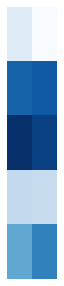

In [259]:
heatmap_plot(df_1)